In [140]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython.display
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [6]:
#Pipeline:
#0normalization
#0linear regression as our baseline

#1Baseline, take mean of the data points (MPG) to determine baseline
    #younes' suggestion when we predict using Total MPG
    #we might just ignore this then

#2Another thing to predict: rate of change of MPG, maybe how much we are accelerating
    #When velocity decreases, how fast are we decreasing by? (acceleration)
    #good idea to create a new parameter on rate of change of speed
    #rate of change of MPG as output - not sure
    

#3Generate test set using equation
    #need some clarification why
    #not useful -> likely quite simple and won't demonstrate the comptuational expensive problem 
    #that we are trying to calculate
    
    #useful -> why compare theoretical values when we have actual values?

#4Remove the features that don't really correlate with our MPG - i dont think that we need to do that

In [158]:
#NEW: write comments?
#OLD: aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set

# cleaned, correct dataset - elaborate on "clean" pls
# cleaned: removed long term fuel trim bank 3,removed some of the
# time columns as well.
# merged all 6 data files with the same features
# also created function to cap instant fuel economy to 45 mpg if larger than 45
files = "./data/merged.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [184]:
# Global parameters
max_num = 45
seed = 9
numEpochs = 500

In [199]:
#To-do: consider experimenting what happens when you remove it.
#if the maxNum = 45, there are ___1788___ obs whose MPG > 45

#a function that rounds down any value above 45 to 45.
#39 is the avg highway IFE. we then choose the number 45.
#see our doc/write up for more info?

def set_max_ifo(dataset, max_num):
    #    count = 0
    copy = dataset.copy()
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 1] > max_Num:
#            count += 1
            copy.iloc[i, len(dataset.columns) - 1] = max_Num
#    print(count)
    return copy
maxed_dataset = set_max_ifo(dataset, max_num)
maxed_dataset.sample(frac=1).reset_index(drop=True)

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
0,14.901960,12.15686,62.6,29.8254,20.00000,885.9030,183.2,1037.25,89.41177,449.6170,0.995550,71.6,10.335540,4.68750,0.345303,10.563310,0.230329,45.000000
1,80.392160,49.41177,78.8,29.8254,71.37255,2704.9570,188.6,1541.50,67.45098,1124.0420,0.996161,80.6,25.100590,7.81250,4.150251,44.117360,2.765729,15.951440
2,23.137250,12.94118,64.4,29.8254,38.03922,1104.4260,186.8,674.50,78.03922,538.0900,0.996100,73.4,15.060350,5.46875,0.423360,3.106856,0.282248,11.007530
3,12.156860,14.50980,62.6,29.5301,12.94118,885.9030,185.0,2617.75,46.66667,474.2734,1.000003,62.6,5.315418,1.56250,0.669438,39.146390,0.444590,45.000000
4,64.705880,29.80392,64.4,29.8254,81.56863,2462.8100,185.0,1231.50,74.50980,1251.6760,0.903105,69.8,27.167690,8.59375,2.261007,23.612100,1.660179,14.222630
5,10.196080,11.37255,73.4,29.8254,12.15686,885.9030,186.8,1350.50,78.03922,459.7696,1.000003,77.0,5.315418,5.46875,0.231525,29.204450,0.153761,45.000000
6,52.549020,24.70588,64.4,29.8254,65.88235,2639.9910,195.8,1431.75,74.50980,1316.9430,0.992531,80.6,26.577090,4.68750,1.906443,11.806050,1.276000,9.252395
7,43.137260,27.05882,62.6,29.8254,49.80392,2518.9170,183.2,2019.75,83.92157,1757.8570,0.994056,66.2,27.167690,7.81250,2.201472,68.972210,1.470121,45.000000
8,22.745100,12.54902,118.4,29.8254,43.52941,1066.0370,194.0,561.50,81.17647,513.4336,0.995246,120.2,14.469750,1.56250,0.321489,0.000000,0.214529,0.000000
9,20.000000,14.50980,62.6,30.1207,23.52941,939.0572,185.0,1305.25,67.45098,459.7696,0.995520,69.8,12.697940,4.68750,0.693252,37.903640,0.464614,45.000000


In [200]:
#Plotting a histograph to see distribution of Vehicle speed (MPH) 
#sns.distplot(maxedDataSet['Vehicle speed (MPH)']);

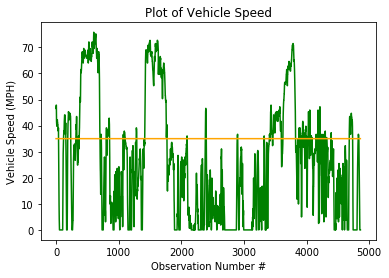

In [201]:
set35 = np.full(4859, 35)
set35
plt.plot(maxed_dataset['Vehicle speed (MPH)'], color='g')
plt.plot(set35, color='orange')
plt.xlabel('Observation Number #')
plt.ylabel('Vehicle Speed (MPH)')
plt.title('Plot of Vehicle Speed')
plt.figure(figsize=(36, 32))
plt.show()

In [202]:
#dataset.iloc[:, len(dataset.columns) - 3] #yes - way to access speed

#a function that counts how many data points are that whose speed is more than 35 
#(meaning that the car is in the highway)

def find_highway_speed(dataset, max_num):
    count = 0
    copy = dataset.copy()
    array_speed = []
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 3] > max_num:
            count += 1
            array_speed.append(i)
    print(count)
    return array_speed

list_highway_speed = find_highway_speed(maxed_dataset, 35)

#for i in range(1,len(list_highway_speed))):
#    print(list_highway_speed[i])

1536


In [203]:
#print(list_highway_speed)
#for i in range(1,len(list_highway_speed))):
#    highway_speed_dataset = maxed_dataset[list_highway_speed[i]]


In [204]:
%%time 
#set seed here!

# Bugs to fix: split evenly driving on the high way vs city (look at speed for this)
# Split evenly the data amongst the datasets



#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(maxed_dataset)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.44 ms


In [205]:
#train.dtypes

In [206]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# train_stats is a pandas data frame type
train_stats = train.describe(include = 'all')
train_stats

train_stats['Vehicle speed (MPH)']

count    2916.000000
mean       26.371411
std        21.997183
min         0.000000
25%         6.213712
50%        24.854850
75%        39.146390
max        75.807290
Name: Vehicle speed (MPH), dtype: float64

In [207]:
train_stats['Vehicle speed (MPH)'][1] #mean

26.371411005281207

In [208]:
#we have to normalize test and validation data set by using the mean and sd from training data set

# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [209]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
#this method normalizes it according to the mean and sd from each set instead of 
#normalizaing from training set only# scaler = StandardScaler()

# a bit buggy
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)



In [210]:
# build models with different number of activation layers and number of nodes to explore
# which one has lowest testing error
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [211]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5)                 90        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________
CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 281 ms


In [25]:
%%time
# Also buggy: 

#change batch size? try early stop - The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))

Instructions for updating:
Use tf.cast instead.
CPU times: user 45.1 s, sys: 20.8 s, total: 1min 5s
Wall time: 27.9 s


In [212]:
%%time

# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=numEpochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Epoch 1/500
 - 0s - loss: 925.1304 - mean_absolute_error: 24.9153 - mean_squared_error: 925.1306 - val_loss: 860.6675 - val_mean_absolute_error: 23.9829 - val_mean_squared_error: 860.6674
Epoch 2/500
 - 0s - loss: 808.2162 - mean_absolute_error: 23.2891 - mean_squared_error: 808.2163 - val_loss: 739.3887 - val_mean_absolute_error: 22.3457 - val_mean_squared_error: 739.3887
Epoch 3/500
 - 0s - loss: 683.3447 - mean_absolute_error: 21.6368 - mean_squared_error: 683.3448 - val_loss: 611.6917 - val_mean_absolute_error: 20.6461 - val_mean_squared_error: 611.6917
Epoch 4/500
 - 0s - loss: 552.4424 - mean_absolute_error: 19.7826 - mean_squared_error: 552.4423 - val_loss: 481.8647 - val_mean_absolute_error: 18.7282 - val_mean_squared_error: 481.8647
Epoch 5/500
 - 0s - loss: 427.5218 - mean_absolute_error: 17.7358 - mean_squared_error: 427.5218 - val_loss: 364.1026 - val_mean_absolute_error: 16.6194 - val_mean_squared_error: 364.1026
Epoch 6/500
 

Epoch 46/500
 - 0s - loss: 31.8575 - mean_absolute_error: 4.0250 - mean_squared_error: 31.8575 - val_loss: 73.8573 - val_mean_absolute_error: 5.9601 - val_mean_squared_error: 73.8573
Epoch 47/500
 - 0s - loss: 31.4505 - mean_absolute_error: 3.9918 - mean_squared_error: 31.4505 - val_loss: 73.6914 - val_mean_absolute_error: 5.9571 - val_mean_squared_error: 73.6914
Epoch 48/500
 - 0s - loss: 31.0548 - mean_absolute_error: 3.9620 - mean_squared_error: 31.0548 - val_loss: 71.9809 - val_mean_absolute_error: 5.8681 - val_mean_squared_error: 71.9809
Epoch 49/500
 - 0s - loss: 30.5369 - mean_absolute_error: 3.9275 - mean_squared_error: 30.5369 - val_loss: 71.2092 - val_mean_absolute_error: 5.8302 - val_mean_squared_error: 71.2092
Epoch 50/500
 - 0s - loss: 30.2285 - mean_absolute_error: 3.8959 - mean_squared_error: 30.2285 - val_loss: 71.3617 - val_mean_absolute_error: 5.8698 - val_mean_squared_error: 71.3617
Epoch 51/500
 - 0s - loss: 29.8174 - mean_absolute_error: 3.8661 - mean_squared_error

Epoch 91/500
 - 0s - loss: 20.4073 - mean_absolute_error: 3.0941 - mean_squared_error: 20.4073 - val_loss: 45.2487 - val_mean_absolute_error: 4.6253 - val_mean_squared_error: 45.2487
Epoch 92/500
 - 0s - loss: 20.2467 - mean_absolute_error: 3.0837 - mean_squared_error: 20.2467 - val_loss: 43.4509 - val_mean_absolute_error: 4.4719 - val_mean_squared_error: 43.4509
Epoch 93/500
 - 0s - loss: 20.1127 - mean_absolute_error: 3.0669 - mean_squared_error: 20.1127 - val_loss: 43.4387 - val_mean_absolute_error: 4.4856 - val_mean_squared_error: 43.4387
Epoch 94/500
 - 0s - loss: 19.8981 - mean_absolute_error: 3.0460 - mean_squared_error: 19.8981 - val_loss: 42.8852 - val_mean_absolute_error: 4.4591 - val_mean_squared_error: 42.8852
Epoch 95/500
 - 0s - loss: 19.8178 - mean_absolute_error: 3.0349 - mean_squared_error: 19.8178 - val_loss: 43.2872 - val_mean_absolute_error: 4.5139 - val_mean_squared_error: 43.2872
Epoch 96/500
 - 0s - loss: 19.6742 - mean_absolute_error: 3.0242 - mean_squared_error

Epoch 136/500
 - 0s - loss: 14.7300 - mean_absolute_error: 2.5967 - mean_squared_error: 14.7300 - val_loss: 30.8495 - val_mean_absolute_error: 3.8461 - val_mean_squared_error: 30.8495
Epoch 137/500
 - 0s - loss: 14.5446 - mean_absolute_error: 2.5808 - mean_squared_error: 14.5446 - val_loss: 30.3682 - val_mean_absolute_error: 3.8059 - val_mean_squared_error: 30.3682
Epoch 138/500
 - 0s - loss: 14.4378 - mean_absolute_error: 2.5751 - mean_squared_error: 14.4378 - val_loss: 30.2423 - val_mean_absolute_error: 3.7854 - val_mean_squared_error: 30.2423
Epoch 139/500
 - 0s - loss: 14.3592 - mean_absolute_error: 2.5690 - mean_squared_error: 14.3592 - val_loss: 29.2971 - val_mean_absolute_error: 3.7269 - val_mean_squared_error: 29.2971
Epoch 140/500
 - 0s - loss: 14.2677 - mean_absolute_error: 2.5658 - mean_squared_error: 14.2677 - val_loss: 29.0165 - val_mean_absolute_error: 3.7050 - val_mean_squared_error: 29.0165
Epoch 141/500
 - 0s - loss: 14.1931 - mean_absolute_error: 2.5549 - mean_squared

Epoch 181/500
 - 0s - loss: 10.4602 - mean_absolute_error: 2.1577 - mean_squared_error: 10.4602 - val_loss: 23.3719 - val_mean_absolute_error: 3.3219 - val_mean_squared_error: 23.3719
Epoch 182/500
 - 0s - loss: 10.4490 - mean_absolute_error: 2.1615 - mean_squared_error: 10.4490 - val_loss: 21.5035 - val_mean_absolute_error: 3.1449 - val_mean_squared_error: 21.5035
Epoch 183/500
 - 0s - loss: 10.3717 - mean_absolute_error: 2.1545 - mean_squared_error: 10.3717 - val_loss: 21.7745 - val_mean_absolute_error: 3.1943 - val_mean_squared_error: 21.7745
Epoch 184/500
 - 0s - loss: 10.3047 - mean_absolute_error: 2.1432 - mean_squared_error: 10.3047 - val_loss: 21.1117 - val_mean_absolute_error: 3.1201 - val_mean_squared_error: 21.1117
Epoch 185/500
 - 0s - loss: 10.1644 - mean_absolute_error: 2.1314 - mean_squared_error: 10.1644 - val_loss: 22.0397 - val_mean_absolute_error: 3.2212 - val_mean_squared_error: 22.0397
Epoch 186/500
 - 0s - loss: 10.0535 - mean_absolute_error: 2.1258 - mean_squared

Epoch 226/500
 - 0s - loss: 7.9432 - mean_absolute_error: 1.8291 - mean_squared_error: 7.9432 - val_loss: 18.0914 - val_mean_absolute_error: 2.8943 - val_mean_squared_error: 18.0914
Epoch 227/500
 - 0s - loss: 7.7677 - mean_absolute_error: 1.8186 - mean_squared_error: 7.7677 - val_loss: 18.6855 - val_mean_absolute_error: 2.9612 - val_mean_squared_error: 18.6855
Epoch 228/500
 - 0s - loss: 7.7500 - mean_absolute_error: 1.8171 - mean_squared_error: 7.7500 - val_loss: 15.9579 - val_mean_absolute_error: 2.6493 - val_mean_squared_error: 15.9579
Epoch 229/500
 - 0s - loss: 7.6833 - mean_absolute_error: 1.8011 - mean_squared_error: 7.6833 - val_loss: 19.6217 - val_mean_absolute_error: 3.0364 - val_mean_squared_error: 19.6217
Epoch 230/500
 - 0s - loss: 7.6475 - mean_absolute_error: 1.8065 - mean_squared_error: 7.6475 - val_loss: 17.8134 - val_mean_absolute_error: 2.8601 - val_mean_squared_error: 17.8134
Epoch 231/500
 - 0s - loss: 7.6295 - mean_absolute_error: 1.7997 - mean_squared_error: 7.6

 - 0s - loss: 6.6201 - mean_absolute_error: 1.6235 - mean_squared_error: 6.6201 - val_loss: 14.6834 - val_mean_absolute_error: 2.6186 - val_mean_squared_error: 14.6834
Epoch 272/500
 - 0s - loss: 6.4392 - mean_absolute_error: 1.6363 - mean_squared_error: 6.4392 - val_loss: 14.0446 - val_mean_absolute_error: 2.5799 - val_mean_squared_error: 14.0446
Epoch 273/500
 - 0s - loss: 6.5697 - mean_absolute_error: 1.6311 - mean_squared_error: 6.5697 - val_loss: 14.3724 - val_mean_absolute_error: 2.5629 - val_mean_squared_error: 14.3724
Epoch 274/500
 - 0s - loss: 6.4652 - mean_absolute_error: 1.6104 - mean_squared_error: 6.4652 - val_loss: 15.5344 - val_mean_absolute_error: 2.6942 - val_mean_squared_error: 15.5344
Epoch 275/500
 - 0s - loss: 6.3521 - mean_absolute_error: 1.6159 - mean_squared_error: 6.3521 - val_loss: 13.3909 - val_mean_absolute_error: 2.4746 - val_mean_squared_error: 13.3909
Epoch 276/500
 - 0s - loss: 6.4366 - mean_absolute_error: 1.6194 - mean_squared_error: 6.4366 - val_loss

Epoch 317/500
 - 0s - loss: 5.7115 - mean_absolute_error: 1.4965 - mean_squared_error: 5.7115 - val_loss: 11.8988 - val_mean_absolute_error: 2.3660 - val_mean_squared_error: 11.8988
Epoch 318/500
 - 0s - loss: 5.6197 - mean_absolute_error: 1.4928 - mean_squared_error: 5.6197 - val_loss: 11.7055 - val_mean_absolute_error: 2.3502 - val_mean_squared_error: 11.7055
Epoch 319/500
 - 0s - loss: 5.6288 - mean_absolute_error: 1.4816 - mean_squared_error: 5.6288 - val_loss: 12.5351 - val_mean_absolute_error: 2.4973 - val_mean_squared_error: 12.5351
Epoch 320/500
 - 0s - loss: 5.5294 - mean_absolute_error: 1.4838 - mean_squared_error: 5.5294 - val_loss: 12.7274 - val_mean_absolute_error: 2.5146 - val_mean_squared_error: 12.7274
Epoch 321/500
 - 0s - loss: 5.6267 - mean_absolute_error: 1.4858 - mean_squared_error: 5.6267 - val_loss: 11.3593 - val_mean_absolute_error: 2.3122 - val_mean_squared_error: 11.3593
Epoch 322/500
 - 0s - loss: 5.5052 - mean_absolute_error: 1.4776 - mean_squared_error: 5.5

 - 0s - loss: 4.9918 - mean_absolute_error: 1.3800 - mean_squared_error: 4.9918 - val_loss: 12.1952 - val_mean_absolute_error: 2.4444 - val_mean_squared_error: 12.1952
Epoch 363/500
 - 0s - loss: 4.9106 - mean_absolute_error: 1.3839 - mean_squared_error: 4.9106 - val_loss: 12.1670 - val_mean_absolute_error: 2.4475 - val_mean_squared_error: 12.1670
Epoch 364/500
 - 0s - loss: 4.8261 - mean_absolute_error: 1.3748 - mean_squared_error: 4.8261 - val_loss: 11.3092 - val_mean_absolute_error: 2.3402 - val_mean_squared_error: 11.3092
Epoch 365/500
 - 0s - loss: 4.8067 - mean_absolute_error: 1.3764 - mean_squared_error: 4.8067 - val_loss: 12.4887 - val_mean_absolute_error: 2.4723 - val_mean_squared_error: 12.4887
Epoch 366/500
 - 0s - loss: 4.9929 - mean_absolute_error: 1.3752 - mean_squared_error: 4.9929 - val_loss: 11.8074 - val_mean_absolute_error: 2.3971 - val_mean_squared_error: 11.8074
Epoch 367/500
 - 0s - loss: 4.8664 - mean_absolute_error: 1.3757 - mean_squared_error: 4.8664 - val_loss

Epoch 408/500
 - 0s - loss: 4.4166 - mean_absolute_error: 1.2748 - mean_squared_error: 4.4166 - val_loss: 10.9353 - val_mean_absolute_error: 2.3072 - val_mean_squared_error: 10.9353
Epoch 409/500
 - 0s - loss: 4.3612 - mean_absolute_error: 1.2821 - mean_squared_error: 4.3612 - val_loss: 9.8472 - val_mean_absolute_error: 2.1598 - val_mean_squared_error: 9.8472
Epoch 410/500
 - 0s - loss: 4.2588 - mean_absolute_error: 1.2806 - mean_squared_error: 4.2588 - val_loss: 10.6604 - val_mean_absolute_error: 2.3129 - val_mean_squared_error: 10.6604
Epoch 411/500
 - 0s - loss: 4.3217 - mean_absolute_error: 1.2836 - mean_squared_error: 4.3217 - val_loss: 10.0344 - val_mean_absolute_error: 2.1994 - val_mean_squared_error: 10.0344
Epoch 412/500
 - 0s - loss: 4.3738 - mean_absolute_error: 1.2747 - mean_squared_error: 4.3738 - val_loss: 12.0106 - val_mean_absolute_error: 2.4301 - val_mean_squared_error: 12.0106
Epoch 413/500
 - 0s - loss: 4.2313 - mean_absolute_error: 1.2688 - mean_squared_error: 4.231

Epoch 454/500
 - 0s - loss: 4.0080 - mean_absolute_error: 1.1970 - mean_squared_error: 4.0080 - val_loss: 12.9590 - val_mean_absolute_error: 2.5528 - val_mean_squared_error: 12.9590
Epoch 455/500
 - 0s - loss: 3.9614 - mean_absolute_error: 1.2104 - mean_squared_error: 3.9614 - val_loss: 11.4245 - val_mean_absolute_error: 2.3869 - val_mean_squared_error: 11.4245
Epoch 456/500
 - 0s - loss: 3.8962 - mean_absolute_error: 1.2035 - mean_squared_error: 3.8962 - val_loss: 11.2217 - val_mean_absolute_error: 2.3444 - val_mean_squared_error: 11.2217
Epoch 457/500
 - 0s - loss: 3.9674 - mean_absolute_error: 1.2062 - mean_squared_error: 3.9674 - val_loss: 10.1992 - val_mean_absolute_error: 2.2373 - val_mean_squared_error: 10.1992
Epoch 458/500
 - 0s - loss: 4.0061 - mean_absolute_error: 1.1892 - mean_squared_error: 4.0061 - val_loss: 11.6907 - val_mean_absolute_error: 2.3983 - val_mean_squared_error: 11.6907
Epoch 459/500
 - 0s - loss: 4.0010 - mean_absolute_error: 1.1955 - mean_squared_error: 4.0

Epoch 500/500
 - 0s - loss: 3.5744 - mean_absolute_error: 1.1448 - mean_squared_error: 3.5744 - val_loss: 9.7882 - val_mean_absolute_error: 2.1658 - val_mean_squared_error: 9.7882
CPU times: user 1min 43s, sys: 41.4 s, total: 2min 24s
Wall time: 1min 6s


In [213]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.xlim([0,500])
  plt.ylim([0,50])
  plt.legend()
  plt.show()

In [ ]:
plot_history(history_object_A)

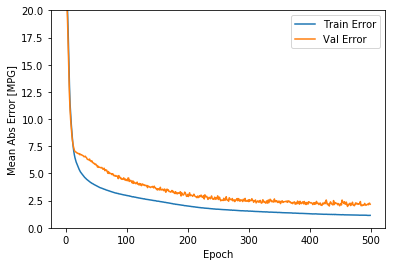

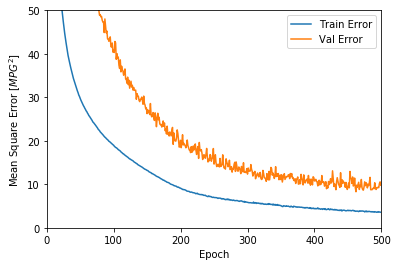

In [214]:
# Increase num epochs? in reference to 2nd graph
# Mean abs error seems to be a better cost function

# For Mean Abs,the variance starts to in|crease after epoch 200, maybe stop there?
# For Mean Square, the variance start to increase after epoch 150, stop here?

# Mean Squared Error seems to be industry standard for regression problems. 
plot_history(history_object_B)

In [233]:
# Range of how wrong we allow a prediction to be, random number for now. 
# unsure what is considered "good"
# discussion: what is a good epsilon value

# errorVec is y - y_hat, abs value will be taken care of inside here
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print("Accuracy: ", (numCorrect / float(numExamples))*100,"%")

In [249]:
# Increased accuracy to 42% after cleaning data and setting maxed IFO
# Epoch is set to 500
epsilon = 1
test_predictions_B = model_B.predict(normed_test).flatten()
test_labels_np = test_labels.values
errorVec = test_predictions_B - test_labels_np
print(max(test_predictions_B))
accuracy(errorVec, epsilon)

85.22929
Accuracy:  46.913580246913575 %


In [240]:
# implementing linear regression 
# build linear model
# TODO: implement linear regression with predictions capped and without predictions capped
# are we also editting our predictions?
lm = LinearRegression()

# the data was editting so that the max IFO is 45
model = lm.fit(normed_train, train_labels)
predictions = lm.predict(normed_test) # this is a np array, be careful

# expects series
def cap_predictions(predictions, max_num):
    copy = np.copy(predictions)
    for index, val in enumerate(copy):
        if val > max_num:
            copy[index] = max_num
        if val < 0:
            copy[index] = 0
    return copy
capped_predictions = cap_predictions(predictions, max_num)

In [241]:
# Linear Regression plot
# lots of weird looking outliers at true values = 0, 45

def plot_scatter(y, y_hat):
    
    plt.figure
    plt.scatter(y, y_hat)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

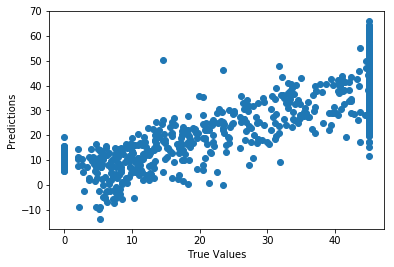

In [242]:
# prediction no cap
plot_scatter(test_labels, predictions)

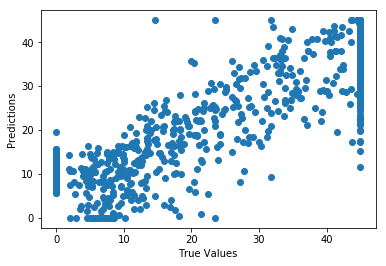

In [243]:
# prediction with cap
plot_scatter(test_labels, capped_predictions)

In [244]:
# Accuracy of linear regression

accuracy(test_labels - predictions, epsilon)
accuracy(test_labels - capped_predictions, epsilon)

Accuracy:  7.510288065843622 %
Accuracy:  18.51851851851852 %
